In [1]:
import numpy as np

""" Example of graph classification problem """
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ModuleList, ReLU, Sequential, Tanh
import torch.nn.functional as F
import os.path as osp
import sys
sys.path.append('/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2')


In [52]:
import numpy as np

""" Example of graph classification problem """
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ModuleList, ReLU, Sequential, Tanh
import torch.nn.functional as F
import os.path as osp
import sys
sys.path.append('/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2')


import random
from datetime import datetime

import numpy as np
import torch
from psd_gnn.dataset import Merge_PSD_Dataset, PSD_Dataset

# from psd_gnn.models.graph_classifier import GNN
from psd_gnn.utils import process_args
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader, ImbalancedSampler, NeighborLoader
from torch.distributions import Gumbel as G
from torch.optim.lr_scheduler import ReduceLROnPlateau


torch.manual_seed(0)
class GNN(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int,
                 node_class: bool=False,
                 n_conv_blocks: int = 1,
                 dropout:float=0.5) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_edge_features (int): Number of features at edge level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()
        
        self.node_class = node_class
        self.dropout = dropout
        conv_blocks_mu = []
        conv_blocks_scale = []
        conv_blocks = []
        
        # if node_class:
        #     print("node")
        #     # ability to  add one or more conv blocks
        #     for _ in range(n_conv_blocks):
        #         conv_blocks += [
        #             GCNConv(n_node_features, n_hidden),
        #             Tanh(),
        #         ] 
            
        #     # ability to  add one or more conv blocks
        #     for _ in range(n_conv_blocks):
        #         conv_blocks_mu += [
        #             GCNConv(n_hidden, n_hidden),
        #         ]
                
        #     # ability to  add one or more conv blocks
        #     for _ in range(n_conv_blocks):
        #         conv_blocks_scale += [
        #             GCNConv(n_hidden, n_hidden),
        #         ]
        # else:
        #     print("graph")
        for _ in range(n_conv_blocks):
            conv_blocks += [
                GCNConv(n_node_features, n_hidden),
                ReLU(),
                GCNConv(n_hidden, n_hidden),
                ReLU(),
            ]

        # The mean block
        for _ in range(n_conv_blocks):
            conv_blocks_mu += [
                GCNConv(n_hidden, 1),
                 ReLU(),
            ]
        # The scale block
        for _ in range(n_conv_blocks):
            conv_blocks_scale += [
                GCNConv(n_hidden,1),
                 ReLU(),
            ]
    
    
        # group all the conv layers
        self.conv_layers       = ModuleList(conv_blocks)
        self.conv_layers_mu    = ModuleList(conv_blocks_mu)
        self.conv_layers_scale = ModuleList(conv_blocks_scale)
        
        
    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor,
                batch: torch.Tensor) -> torch.Tensor:
        """ Processing the GNN model.
        Args:
            x (torch.Tensor): Input features at node level.
            edge_index (torch.Tensor): Index pairs of vertices
        Returns:
            torch.Tensor: output tensor.
        """
        # process the layers
        for layer in (self.conv_layers):
            if isinstance(layer, GCNConv):
                x = layer(x, edge_index)
            else:
                x = layer(x)
                
        mu = x
        for layer in self.conv_layers_mu:
            if isinstance(layer, GCNConv):
                mu = layer(mu, edge_index)
            else:
                mu = layer(mu)
             
        # process the layers
        scale = x
        for layer in self.conv_layers_scale:
            if isinstance(layer, GCNConv):
                scale = layer(scale,  edge_index)
            else:
                scale = layer(scale)
                
        ## NOTE: add the readout layer
        if self.node_class:
            # print("node")
            return torch.exp(mu), torch.exp(scale)
        else:
            return torch.exp(gap(mu, batch)), torch.exp(gap(scale, batch))
    
        

        
class Gumbel_GNN(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int,
                 node_class: bool=False,
                 n_conv_blocks: int = 1,
                 dropout:float= 0.5) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_edge_features (int): Number of features at edge level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()
        self.node_class = node_class

        self.encoder = GNN(n_node_features, n_hidden, n_output,\
            self.node_class, n_conv_blocks, dropout)
        
        self.summary_statistics= Sequential( Linear(1, n_hidden),
                                ReLU(),
                                Linear(n_hidden, n_hidden), 
                                ReLU(),
                                Linear(n_hidden, n_output) 
                                )
        
        self.likelihood_g_loss= torch.nn.BCEWithLogitsLoss()
        self.dist = G(torch.tensor([0.8]), torch.tensor([5]))
        self.KLD= torch.nn.KLDivLoss()

    def sample_G(self, mu, scale, n_samples=1): 
        return mu+torch.Tensor(scale.shape, dtype=torch.float)).uniform_(0, 1)*scale
    
    def likelihood_f(self, mu, scale, sample, n=32):
        Z = torch.exp(-1*(sample-mu)/(scale+1e-10))
        likeli =(Z/scale+1e-10)*torch.exp(-1*Z)
        return torch.mean(-1*torch.log(likeli)), likeli

    def likelihood_g(self, out, y):
        # print(out.shape, y.shape)
        return ( torch.mean(self.likelihood_g_loss(out, y)) )

    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor,
                batch: torch.Tensor, 
                temp: float)\
                -> torch.Tensor:
        z_mu, z_sigma = self.encoder(x, edge_index, batch)    
        z_sample = self.sample_G(z_mu, z_sigma)
        out = self.summary_statistics(z_sample)
        return out.view(-1,1), z_mu, z_sigma, z_sample
    
    
    def loss_func(self, out, y,  z_mu, z_sigma, z_sample):
        # The likelihood of g (the output model that classifies)
        loss_likeli_g  =  self.likelihood_g(out.view(-1), y.view(-1).float())
        

        # The likelihood of f (the likelihood of the latent space, puts the constraint)
        loss_likeli_f, q_z_sample  \
                       = self.likelihood_f(z_mu, z_sigma, z_sample)
        
        # ## The entropic prior constraint on the output space
        q_z            =  self.dist.log_prob(self.dist.sample([z_sample.shape[0]]))
        q_z_sample     =  torch.log(q_z_sample)
        
        # ## The entropy of the latent space.
        loss_entropy   =  -1*torch.mean(q_z_sample- q_z\
                          -torch.mul(q_z_sample\
                          ,torch.log(q_z_sample/(q_z+1e-10) ) ) )
        
        
        return loss_likeli_g, loss_likeli_f, loss_entropy
    # +0.5*self.KLD((torch.log(q_z)+torch.normal(0, 0.1, q_z.shape)), z_sample), loss_entropy
    
    
def train(model, loader, weight_loss=[1, 1, 1]):
    """ Train function

    Args:
        model (object): GNN model instance.
        loader (pyg.loader.DataLoader): Data loader object.

    Returns:
        float: Training accuracy.
    """
    
    
    model.train()
    total_loss = 0
    total_F = 0
    total_G = 0
    total_Ent = 0
    out_ret = []
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        out, z_mu, z_sigma, z_sample = model(data.x, data.edge_index, data.batch, temp)
        loss_g, loss_f, loss_entropy  = model.loss_func(out.float(), data.y.unsqueeze(1),\
        z_mu.float(), z_sigma.float(), z_sample.float())
        (weight_loss[0]*loss_g+weight_loss[1]*loss_f+weight_loss[2]*loss_entropy).backward()
        
        optimizer.step()
        
        total_loss += float(( weight_loss[0]*loss_f\
                             +weight_loss[1]*loss_g\
                             +weight_loss[2]*loss_entropy).item() ) * data.num_graphs
        total_F    += float(loss_f.item()) * data.num_graphs
        total_G    += float(loss_g.item()) * data.num_graphs
        total_Ent  += float(loss_entropy.item()) * data.num_graphs
        
        out_ret+= out.squeeze(1).detach().numpy().tolist()
    
    return [total_loss/len(loader.dataset), total_F/len(loader.dataset), total_G/len(loader.dataset),\
        total_Ent/len(loader.dataset)], out_ret
           
    
    
import sklearn
@torch.no_grad()
def test(model, loader, test=64):
    """ Evaluation function.

    Args:
        model (object): GNN model instance.
        loader (pyg.loader.DataLoader): Data loader object.

    Returns:
        tuple (float, list): Testing accuracy, predicted labels.
    """
    model.eval()
    total_correct = 0
    y_pred = []
    y_true = []
    total = []
    for data in loader:
        data = data.to(DEVICE)
        out, _, _, z = model(data.x, data.edge_index, data.batch, test)
        pred = torch.sigmoid(out)
        # print(z.shape)
        out_pred = (pred >= torch.tensor([0.8])).to(torch.int32)
        y_pred += out_pred.detach().cpu().numpy().tolist()
        total  += pred.detach().cpu().numpy().tolist()
        y_true += data.y.detach().cpu().numpy().tolist()
    accuracy = sklearn.metrics.accuracy_score(y_pred, y_true)
    return accuracy, np.array(total).reshape([-1]).tolist()

the model is defined


all:   0%|          | 0/50 [00:02<?, ?it/s, total, f, g, ent=[0.6168157602908343, 1.1378559706479134, 0.5966569562635479, -0.936267970934422], train_acc=0.0888, test_acc=1]

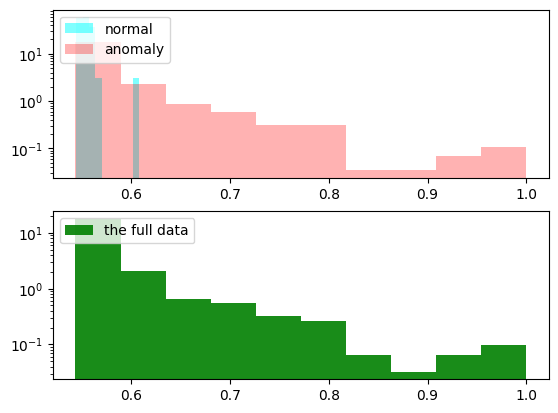

all:  20%|██        | 10/50 [00:13<00:36,  1.11it/s, total, f, g, ent=[0.2030220751226301, 1.1294482085831772, 0.18054386973381042, -0.9046661063764222], train_acc=0.855, test_acc=0.961]

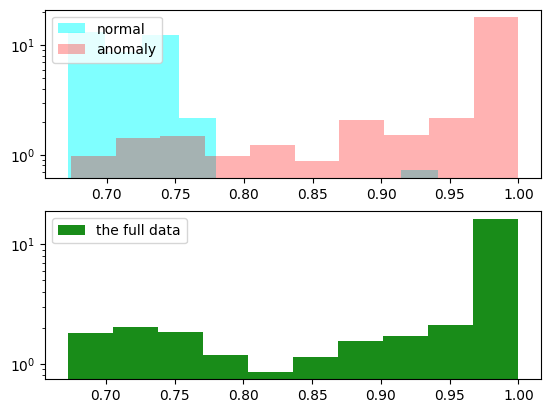

all:  40%|████      | 20/50 [00:24<00:31,  1.06s/it, total, f, g, ent=[0.13133164887597576, 1.1331152182358961, 0.11117938813373182, -0.9315926069338646], train_acc=0.976, test_acc=1]   

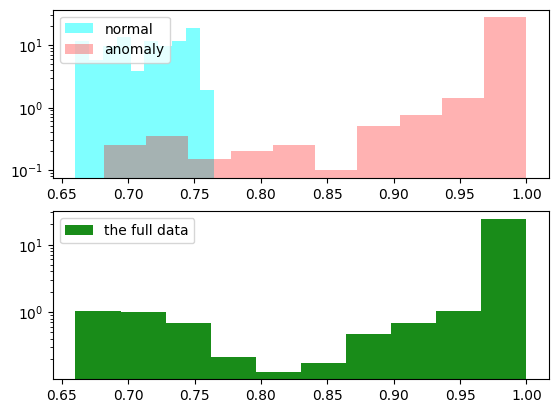

all:  60%|██████    | 30/50 [00:36<00:21,  1.10s/it, total, f, g, ent=[0.10600592513408887, 1.1279854365354458, 0.08772826820788299, -0.9452088605722732], train_acc=0.988, test_acc=1]

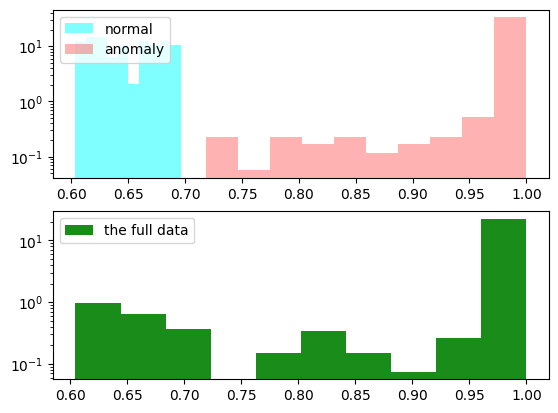

all:  80%|████████  | 40/50 [00:49<00:13,  1.37s/it, total, f, g, ent=[0.09738089933374225, 1.1364605250443227, 0.07017289269605331, -0.8643804760374261], train_acc=0.997, test_acc=1]

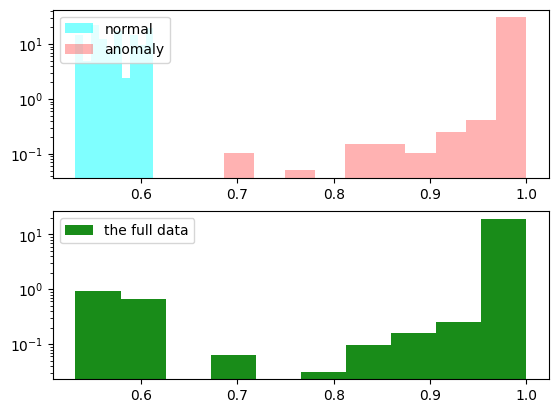

all: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it, total, f, g, ent=[0.08008426502787855, 1.138843875664931, 0.05596731616371482, -0.8976743968986195], train_acc=0.996, test_acc=1] 


In [53]:
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")


## The Graph data, I am going to replace this with 
# some Gaussian and check what is going on
dataset = PSD_Dataset('./','1000genome_new_2022',\
                binary_labels=True,\
                anomaly_cat='all'\
                ).shuffle()

## generate data
import torch
normal__ = []
anomaly__ =[]
for (i,data) in enumerate(dataset):
        if data.y==0:
                data.x.uniform_(2, 10)
                anomaly__.append(i)
        else:
                data.x.normal_(mean = 0, std = 3)
                normal__.append(i)

dataset_N = dataset[normal__]
dataset_A = dataset[anomaly__] 
n_graphs  = len(dataset)

# train_idx, val_idx \
#         = train_test_split( np.arange(n_graphs),\
#         train_size=0.6, random_state=0, shuffle=True)

train_loader = DataLoader(dataset, batch_size=64)
val_loader   = DataLoader(dataset_N,  batch_size=64)
test_loader  = DataLoader(dataset_A, batch_size=64)

NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = 1
# print(n_graphs)



''' Build GNN model '''
model = Gumbel_GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES, False).to(DEVICE)

print("the model is defined")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(50), desc=f"all")
best = 0
temp = 0.5

for e in pbar:
    model.train()
    optimizer.zero_grad()
    train_loss, outputs = train(model, train_loader, weight_loss=[0.1, 1, 0.1])
    train_acc, y_pred   =  test(model, train_loader)
    test_acc, _         =  test(model, test_loader)
   
    pbar.set_postfix({"total, f, g, ent": train_loss,
                      "train_acc": train_acc,
                      "test_acc": test_acc})
    scheduler.step(train_loss[0])
 
    if e%10==0:       
        # actual_Data = G(torch.tensor([0.8]), torch.tensor([0.05])).sample([10000])
        # probs =G(torch.tensor([0.8]), torch.tensor([0.05])).log_prob(actual_Data).exp().squeeze(1).detach().numpy()
        # args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
        # probs = probs[args]
        # actual_Data = actual_Data[args]
        
        fig,axs           = plt.subplots(2)
        _, test_outputs   = test(model, test_loader, 64)
        _, val_outputs    = test(model, val_loader,  64) 
        _, train_outputs  = test(model, train_loader,64)  
        # plt.plot(actual_Data, probs)
        # print(test_outputs.shape)
        # plt.hist(outputs, log=True, label='train', density =True)
        # print( len(test_outputs) )
        
        axs[0].hist(test_outputs, alpha = 0.5, log=True, color = 'cyan', label="normal", density=True)
        axs[0].hist( val_outputs, alpha = 0.3, log=True, color='red', label= "anomaly", density=True)
        axs[0].legend(loc='upper left')
        axs[1].hist( train_outputs, alpha = 0.9, log=True, color='green', label= "the full data", density=True)
        axs[1].legend(loc='upper left')
    
        plt.show()
        

the model is defined


all:   0%|          | 0/100 [00:00<?, ?it/s, total, f, g, ent=[0.4886263884030856, 1.1452545026350303, 0.463884503883723, -0.8978357343278693], train_acc=0.0769, test_acc=1]

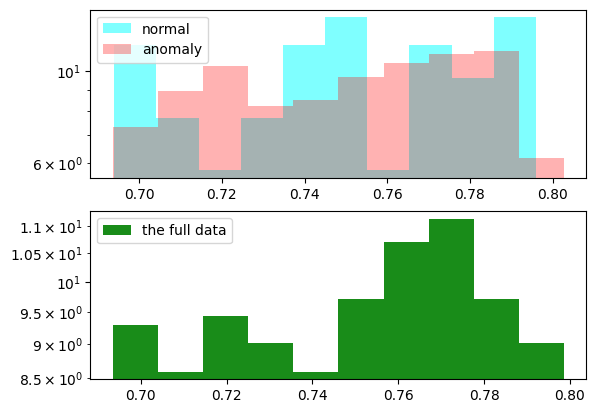

all:  10%|█         | 10/100 [00:19<03:23,  2.26s/it, total, f, g, ent=[0.28567092658499993, 1.1356905973874605, 0.2674349052666207, -0.9533304462771444], train_acc=0.925, test_acc=0]

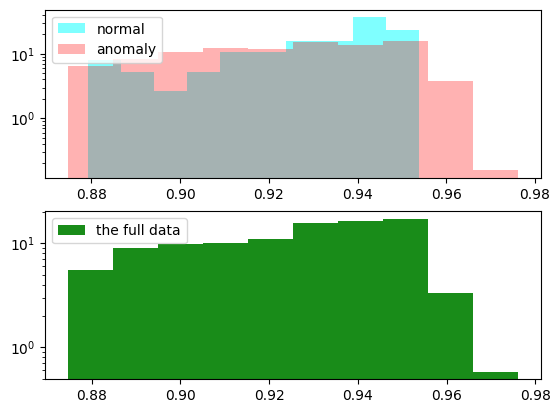

all:  20%|██        | 20/100 [00:37<01:52,  1.40s/it, total, f, g, ent=[0.2658022735598525, 1.1363669118937656, 0.241806157947292, -0.8964058284223433], train_acc=0.925, test_acc=0]   

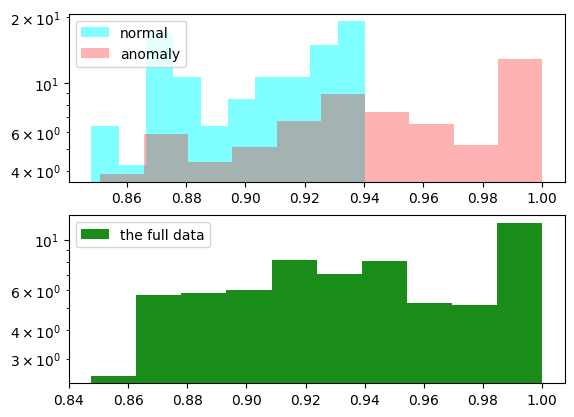

all:  30%|███       | 30/100 [00:48<01:15,  1.07s/it, total, f, g, ent=[0.22119478361141046, 1.1296580804170235, 0.19944122662911049, -0.9121225324608165], train_acc=0.944, test_acc=0.216]

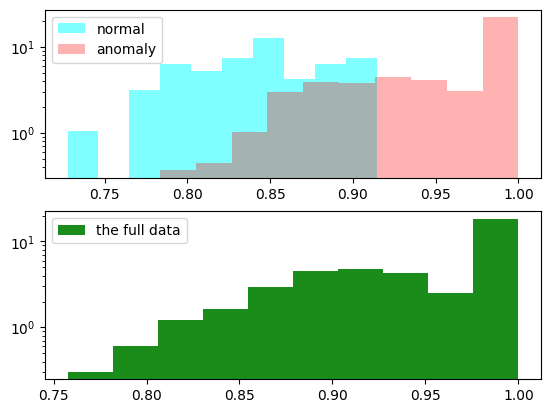

all:  40%|████      | 40/100 [01:04<01:37,  1.63s/it, total, f, g, ent=[0.1989153528354577, 1.1258542015707704, 0.18203824238311608, -0.9570830679504123], train_acc=0.896, test_acc=0.784] 

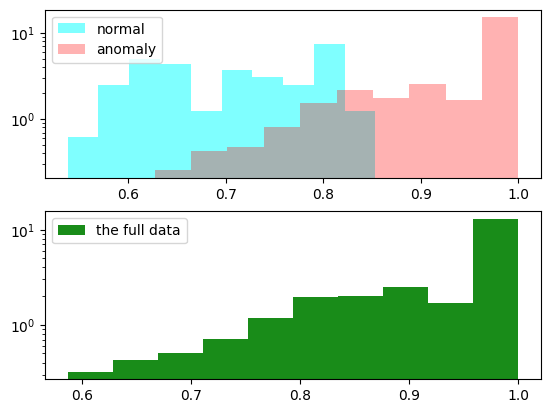

all:  50%|█████     | 50/100 [01:17<00:48,  1.03it/s, total, f, g, ent=[0.1558693134220394, 1.129766511493886, 0.13296414162280293, -0.9007147896219287], train_acc=0.953, test_acc=0.843]  

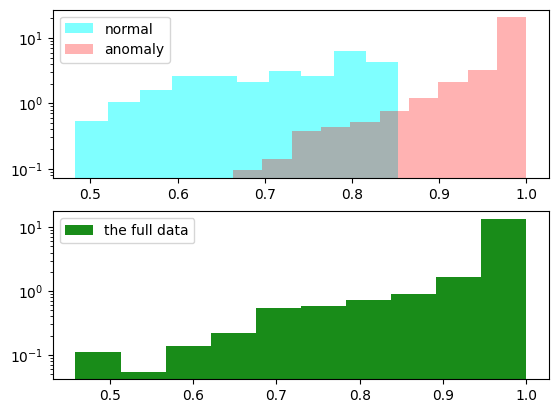

all:  60%|██████    | 60/100 [01:27<00:36,  1.11it/s, total, f, g, ent=[0.11779563393465867, 1.135811588467931, 0.09415232826619459, -0.8993784933400577], train_acc=0.938, test_acc=1]    

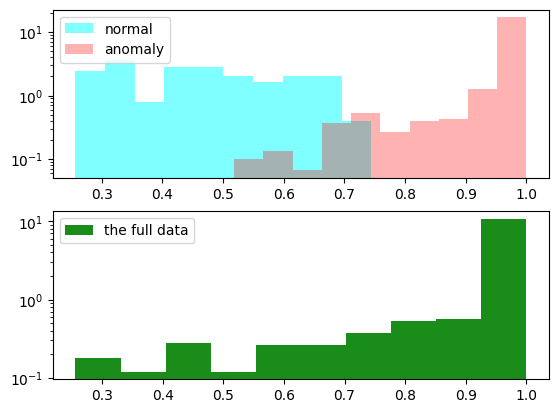

all:  70%|███████   | 70/100 [01:37<00:26,  1.12it/s, total, f, g, ent=[0.10492120828677917, 1.1371880579276903, 0.08342698644075168, -0.9222458445814234], train_acc=0.917, test_acc=1]

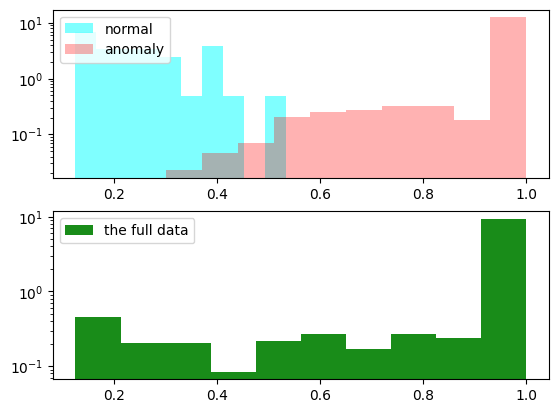

all:  80%|████████  | 80/100 [01:47<00:17,  1.12it/s, total, f, g, ent=[0.0757232637712236, 1.1242417795418282, 0.05326044797544649, -0.899613624141061], train_acc=0.945, test_acc=1]     

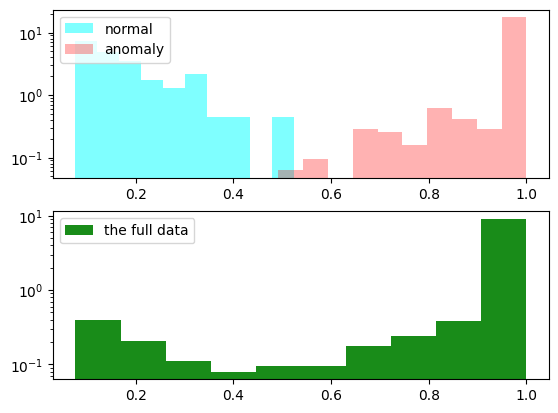

all:  90%|█████████ | 90/100 [02:02<00:14,  1.47s/it, total, f, g, ent=[0.05654956942655631, 1.1342737985080515, 0.03657828114882729, -0.9345609055468317], train_acc=0.972, test_acc=1] 

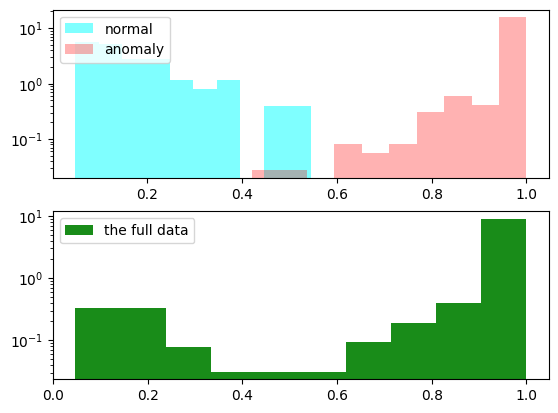

all: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it, total, f, g, ent=[0.07184001274362824, 1.1303929245683568, 0.04830262012030246, -0.8950190078577346], train_acc=0.997, test_acc=1]


In [54]:
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")


## The Graph data, I am going to replace this with 
# some Gaussian and check what is going on
dataset = PSD_Dataset('./','1000genome_new_2022',\
                binary_labels=True,\
                anomaly_cat='all'\
                ).shuffle()

## generate data
import torch
normal__ = []
anomaly__ =[]
for (i,data) in enumerate(dataset):
        if data.y==0:
                # data.x.uniform_(2, 10)
                anomaly__.append(i)
        else:
                # data.x.normal_(mean = 0, std = 3)
                normal__.append(i)

dataset_N = dataset[normal__]
dataset_A = dataset[anomaly__] 
n_graphs  = len(dataset)

# train_idx, val_idx \
#         = train_test_split( np.arange(n_graphs),\
#         train_size=0.6, random_state=0, shuffle=True)

train_loader = DataLoader(dataset, batch_size=64)
val_loader   = DataLoader(dataset_N,  batch_size=64)
test_loader  = DataLoader(dataset_A, batch_size=64)

NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = 1
# print(n_graphs)



''' Build GNN model '''
model = Gumbel_GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES, False).to(DEVICE)

print("the model is defined")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(100), desc=f"all")
best = 0
temp = 0.5

for e in pbar:
    model.train()
    optimizer.zero_grad()
    temp=temp*0.99
    train_loss, outputs = train(model, train_loader,  weight_loss=[0.1, 1, 0.1])
    train_acc, y_pred   =  test(model, train_loader)
    test_acc, _         =  test(model, test_loader)
   
    pbar.set_postfix({"total, f, g, ent": train_loss,
                      "train_acc": train_acc,
                      "test_acc": test_acc})
    scheduler.step(train_loss[0])
 
    if e%10==0:       
        # actual_Data = G(torch.tensor([0.8]), torch.tensor([0.05])).sample([10000])
        # probs =G(torch.tensor([0.8]), torch.tensor([0.05])).log_prob(actual_Data).exp().squeeze(1).detach().numpy()
        # args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
        # probs = probs[args]
        # actual_Data = actual_Data[args]
        
        fig,axs           = plt.subplots(2)
        _, test_outputs   = test(model, test_loader, 64)
        _, val_outputs    = test(model, val_loader,  64) 
        _, train_outputs  = test(model, train_loader,64)  
        # plt.plot(actual_Data, probs)
        # print(test_outputs.shape)
        # plt.hist(outputs, log=True, label='train', density =True)
        # print( len(test_outputs) )
        
        axs[0].hist(test_outputs, alpha = 0.5, log=True, color = 'cyan', label="normal", density=True)
        axs[0].hist( val_outputs, alpha = 0.3, log=True, color='red', label= "anomaly", density=True)
        axs[0].legend(loc='upper left')
        axs[1].hist( train_outputs, alpha = 0.9, log=True, color='green', label= "the full data", density=True)
        axs[1].legend(loc='upper left')
    
        plt.show()
        

In [70]:
# DATA WITHOU LABELS FOR ONE THING
import copy
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")


## The Graph data, I am going to replace this with 
# some Gaussian and check what is going on
dataset = PSD_Dataset('./','1000genome_new_2022',\
                binary_labels=True,\
                anomaly_cat='all'\
                ).shuffle()

## generate data
import torch
normal__ = []
dataset_train_N = []
anomaly__ =[]
for (i,data) in enumerate(dataset):
        data.y = 1-data.y
        if data.y==1:
                data_D =copy.copy(data)
                data_D.x = data.x + torch.normal(0, 1, data.x.shape)
                data_D.y = 1-data_D.y
                normal__.append(i)
                dataset_train_N.append(data_D) 
        else:
                # data.x.normal_(mean = 0, std = 3)
                anomaly__.append(i)

dataset_N = dataset[normal__]
dataset_A = dataset[anomaly__] 
dataset_train= dataset_N+dataset_train_N

# n_graphs  = len(dataset_A)
# train_idx, val_idx \
#         = train_test_split( np.arange(n_graphs),\
#       train_size=0.6, random_state=0, shuffle=True)

train_loader = DataLoader(dataset_train, batch_size=64)
val_loader   = DataLoader(dataset_N,  batch_size=64)
test_loader  = DataLoader(dataset_A, batch_size=64)



''' Build GNN model '''
model = Gumbel_GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES, False).to(DEVICE)

print("the model is defined")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(100), desc=f"all")
best = 0
temp = 0.5
init = [0.1, 1, 10]
for e in pbar:
    model.train()
    optimizer.zero_grad()
    temp=temp*0.99
    weights = [init[0]*1.01, init[1]*0.99, init[2]*0.99]
    train_loss, outputs = train(model, train_loader,  weight_loss=weights)
    train_acc, y_pred   =  test(model, train_loader)
    test_acc, _         =  test(model, test_loader)
   
    pbar.set_postfix({"total, f, g, ent": train_loss,
                      "train_acc": train_acc,
                      "test_acc": test_acc})
    scheduler.step(train_loss[0])
 
    if e%10==0:       
        # actual_Data = G(torch.tensor([0.8]), torch.tensor([0.05])).sample([10000])
        # probs =G(torch.tensor([0.8]), torch.tensor([0.05])).log_prob(actual_Data).exp().squeeze(1).detach().numpy()
        # args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
        # probs = probs[args]
        # actual_Data = actual_Data[args]
        
        fig,axs           = plt.subplots(2)
        _, test_outputs   = test(model, test_loader, 64)
        _, val_outputs    = test(model, val_loader,  64) 
        _, train_outputs  = test(model, train_loader,64)  
        # plt.plot(actual_Data, probs)
        # print(test_outputs.shape)
        # plt.hist(outputs, log=True, label='train', density =True)
        # print( len(test_outputs) )
        
        axs[0].hist(test_outputs, alpha = 0.5, log=True, color = 'cyan', label="normal", density=True)
        axs[0].hist( val_outputs, alpha = 0.3, log=True, color='red', label= "anomaly",  density=True)
        axs[0].legend(loc='upper left')
        axs[1].hist( train_outputs, alpha = 0.9, log=True, color='green', label= "the full data", density=True)
        axs[1].legend(loc='upper left')
    
        plt.show()
        

the model is defined


all:   0%|          | 0/100 [00:00<?, ?it/s]


TypeError: train() missing 2 required positional arguments: 'optimizer_G' and 'optimizer_D'

In [ ]:

NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = 1
# print(n_graphs)

''' Build GNN model '''
model = Gumbel_GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES, False).to(DEVICE)

print("the model is defined")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(5000), desc=f"all")
best = 0
temp = 0.5

for e in pbar:
    
    model.train()
    optimizer.zero_grad()
    temp=temp*0.99
    train_loss, outputs = train(model, train_loader, temp)
    train_acc, y_pred   = test(model, train_loader,  temp)
    test_acc, _         = test(model, test_loader,   temp)
   
    pbar.set_postfix({"total, f, g, ent": train_loss,
                      "train_acc": train_acc,
                      "test_acc": test_acc})
    scheduler.step(train_loss[0])
 
    if e%100==0:       
        # actual_Data = G(torch.tensor([0.8]), torch.tensor([0.05])).sample([10000])
        # probs =G(torch.tensor([0.8]), torch.tensor([0.05])).log_prob(actual_Data).exp().squeeze(1).detach().numpy()
        # args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
        # probs = probs[args]
        # actual_Data = actual_Data[args]
        
        fig,axs = plt.subplots(2)
        _, test_outputs = test(model, test_loader, 64)
        _, val_outputs  = test( model, val_loader,  64) 
        
        # plt.plot(actual_Data, probs)
        # print(test_outputs.shape)
        # plt.hist(outputs, log=True, label='train', density =True)
        # print( len(test_outputs) )
        
        axs[0].hist(test_outputs, alpha = 0.5, log=True, color = 'cyan', label="anomaly", density=True)
        axs[0].hist( val_outputs, alpha = 0.3, log=True, color='red', label= "normal", density=True)
        axs[1].legend(loc='upper left')
        axs[1].hist( test_outputs, alpha = 0.9, log=True, color='green', label= "anomaly", density=True)
        axs[1].legend(loc='upper left')
    
        plt.show()
        
        

In [ ]:
## The final training metrics
ys = []
train_acc, y_pred = test(model, train_loader)
for data in train_loader:
    # ys.append(data.y.item())
    ys += data.y.detach().cpu().numpy().tolist()
y_true = ys
print(confusion_matrix(y_true, y_pred))

test_acc, y_pred = test(model, test_loader)

y_true = []
for data in test_loader:
    y_true += data.y.detach().cpu().numpy().tolist()

print(np.unique(y_pred, return_counts=True), \
     "real", np.unique(y_true, return_counts=True) )

conf_mat = confusion_matrix(y_true, y_pred)
prec_val = precision_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)


print("graph level clf:",
      f"workflow all",
      f"binary True",
      f"test acc {test_acc:.4f}",
      f"f1 {f1_val:.4f}",
      f"recall {recall_val:.4f}",
      f"prec {prec_val:.4f}",
      )
print(conf_mat)

In [ ]:
# GAN ATTEMPT

In [245]:
import numpy as np

""" Example of graph classification problem """
from tqdm import tqdm
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ModuleList, ReLU, Sequential, Tanh
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
import os.path as osp
import sys
sys.path.append('/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2')


import random
from datetime import datetime

import numpy as np
import torch
from psd_gnn.dataset import Merge_PSD_Dataset, PSD_Dataset

# from psd_gnn.models.graph_classifier import GNN
from psd_gnn.utils import process_args
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader, ImbalancedSampler, NeighborLoader
from torch.distributions import Gumbel as G
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch_geometric

torch.manual_seed(0)
class Embedding(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int=64,
                 node_class: bool=False,
                 n_conv_blocks: int = 1,
                 dropout:float=0.5) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_edge_features (int): Number of features at edge level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()
        conv_blocks = [ (GCNConv(n_node_features, n_hidden),'x, edge_index -> x'),
                torch.nn.LeakyReLU(0.2),
                (GCNConv(n_hidden, n_hidden),'x, edge_index -> x'),
                torch.nn.LeakyReLU(0.2),
                (gap, 'x, batch-> x') ]
        # group all the conv layers
        self.conv_GNN =torch_geometric.nn.Sequential('x, edge_index, batch', conv_blocks)
        
    def forward(self, x, edge, batch):
        return self.conv_GNN(x, edge, batch)
        
            
        
        
        
class Generator(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int=1,
                 n_lin_blocks: int = 1,
                 dropout:float=0.5) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_edge_features (int): Number of features at edge level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()
        self.dropout = dropout
        lin_blocks_mu = []
        lin_blocks_scale = []
        lin_blocks = []
        
        lin_blocks += [
                Linear(n_hidden, n_hidden),
                torch.nn.LeakyReLU(0.2),
                Linear(n_hidden, n_hidden),
                torch.nn.LeakyReLU(0.2, inplace=False),
            ]
        # The mean block
        lin_blocks_mu += [
                Linear(n_hidden, n_hidden),
                Tanh(),
            ]
        # The scale block
        lin_blocks_scale += [
                Linear(n_hidden, n_hidden),
                Tanh(),
            ]
    
    
        # group all the conv layers
        self.lin_layers       = Sequential(*lin_blocks)
        self.lin_layers_mu    = Sequential(*lin_blocks_mu)
        self.lin_layers_scale = Sequential(*lin_blocks_scale)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        """ Processing the generator.
        Args:
            x (torch.Tensor): Input features at node level.
        Returns:
            torch.Tensor: output tensor.
        """
        out_lin=self.lin_layers (x)
        mu = self.lin_layers_mu(out_lin )
        scale = self.lin_layers_scale(out_lin)
        return mu, torch.exp(scale)

        
class Gumbel_GNN(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int,
                 node_class: bool=False,
                 n_conv_blocks: int = 1,
                 n_lin_blocks:int=1,
                 dropout:float= 0.5) -> None:
        """ Init the GNN model (new version)
        Args:
            n_node_features (int): Number of features at node level.
            n_edge_features (int): Number of features at edge level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()
        self.node_class = node_class

        self.embedding            = Embedding(n_node_features)
        self.encoder_gener        =  Generator(n_node_features, n_hidden, n_output)      
        self.summary_statistics_g = Sequential( Linear(n_hidden, n_hidden),
                                    torch.nn.LeakyReLU(0.2),
                                    Linear(n_hidden, n_hidden), 
                                    torch.nn.LeakyReLU(0.2),
                                    Linear(n_hidden, n_output) 
                                    )
        
        self.loss= torch.nn.BCELoss(reduction='none')
        self.gumbel_dist = G(torch.tensor([0.8] ), torch.tensor([5.0]))

    def sample_G(self, mu, scale, n_samples=1): 
        samp = mu+torch.normal(0, 1, size=scale.size())*scale
        print(samp, mu, scale)
        return samp
    
    def likelihood_f(self, mu, scale, sample, n=32):
        Z = torch.exp(-1*(sample-mu)/(scale+1e-10))
        likeli =(Z/scale+1e-10)*torch.exp(-1*Z)
        return torch.mean(-1*torch.log(likeli)), likeli

    def likelihood_g(self, out, y):
        # print(out.shape, y.shape)
        return self.loss(out, y)

    def forward(self,
                x: torch.Tensor,
                z_fake:torch.Tensor,
                edge_index: torch.Tensor,
                batch: torch.Tensor)\
                -> torch.Tensor:
               
        
        real = self.embedding.forward(x     , edge_index, batch) 
        fake = self.embedding.forward(z_fake, edge_index, batch) 
        
        z_mu_fake, z_sigma_fake = self.encoder_gener.forward(fake)  
         
        z_sample_fake = self.sample_G(z_mu_fake, z_sigma_fake)
        
        # print(real.shape, z_sample_fake.shape)
        real_out = torch.sigmoid(self.summary_statistics_g(real+torch.normal(0, 0.1, real.shape)))
        fake_out = torch.sigmoid(self.summary_statistics_g(z_sample_fake+torch.normal(0, 0.1, z_sample_fake.shape)))
        
        # print(real.shape, fake.shape)
        return real_out.view(-1,1), fake_out.view(-1,1), z_mu_fake, z_sigma_fake, z_sample_fake
    
    
    def ret_grad_norm(self, dat, loss, p=2, k=2):
        grad_out = Variable( (torch.randn(dat.size())*0.0+1.0), requires_grad=False)
        # print(grad_out.shape, dat.shape, loss.size(), loss)
        grad = autograd.grad(loss.view(-1,1), dat, grad_out, create_graph=True, retain_graph=True, only_inputs=True )[0]
        # print("grad", grad.shape)
        return grad.pow(2).sum(1) ** (p/ 2)
        
    def loss_func(self, z_mu, z_sigma, z_sample, real, fake, y, p=6, k=2):
        # The likelihood of g (the output model that classifies)
        # print(real.shape, fake.shape, y.shape)
        # loss_likeli_g_real  =  self.likelihood_g(real.view(-1), y.view(-1).float())
        # loss_likeli_g_fake  =  self.likelihood_g(fake.view(-1), y.view(-1).float())
        
        loss_likeli_g_real  =  -1*torch.log(real)
        loss_likeli_g_fake  =  -1*torch.log(fake)
         
        
        # print(loss_likeli_g_fake, loss_likeli_g_real)
        real_grad_norm = self.ret_grad_norm(real, loss_likeli_g_real)
        fake_grad_norm = self.ret_grad_norm(fake, loss_likeli_g_fake)
        
        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(loss_likeli_g_fake) + torch.mean(loss_likeli_g_real) + div_gp
        
        
        # The likelihood of f (the likelihood of the latent space, puts the constraint)
        loss_likeli_f, q_z_sample = self.likelihood_f(z_mu, z_sigma, z_sample)
                
        # # ## The entropic prior constraint on the output space
        q_z            =  self.gumbel_dist.log_prob(self.gumbel_dist.sample([z_sample.shape[0]]))
        q_z_sample     =  torch.log(q_z_sample)
        
        ### The entropy of the latent space.
        loss_entropy   =  -1*torch.mean(q_z_sample- q_z\
                          -torch.mul(q_z_sample\
                          ,torch.log(q_z_sample/(q_z+1e-10) ) ) )
        
        # print(d_loss, loss_likeli_f, loss_entropy)
        return d_loss, (loss_likeli_f+loss_entropy)
    
    # +0.5*self.KLD((torch.log(q_z)+torch.normal(0, 0.1, q_z.shape)), z_sample), loss_entropy
    
    
def train(model, loader, optimizer_G, optimizer_D, weight_loss=[1, 1]):
    """ Train function

    Args:
        model (object): GNN model instance.
        loader (pyg.loader.DataLoader): Data loader object.

    Returns:
        float: Training accuracy.
    """
    model.train()
    total_loss = 0
    total_F = 0
    total_G = 0
    total_Entire = 0
    out_ret = []
    for (i,data) in enumerate(loader):
        data = data.to(DEVICE)
        
        real, fake, z_mu, z_sigma, z_sample = model(data.x, torch.normal(0, 1, size=data.x.shape),\
                                              data.edge_index, data.batch)
        
        disc_loss, gen_loss = model.loss_func(z_mu.float(), z_sigma.float(),\
            z_sample.float(), real.float(), fake.float(), data.y.unsqueeze(1))
        
        total_loss = disc_loss-gen_loss
        optimizer_D.zero_grad()
        (total_loss).backward(create_graph=True)
        optimizer_D.step()

        
        if (i%2==0):
           optimizer_G.zero_grad()
           optimizer_G.step() 

        total_Entire += float(total_loss.item()) * data.num_graphs 
        total_F    += float(disc_loss.item()) * data.num_graphs
        total_G    += float( gen_loss.item()) * data.num_graphs
        out_ret+= real.squeeze(1).detach().numpy().tolist()
    
    return [(total_Entire/len(loader.dataset)), total_F/len(loader.dataset), total_G/len(loader.dataset)], out_ret
           
    
import sklearn
@torch.no_grad()
def test(model, loader, test=64):
    """ Evaluation function.



    Args:
        model (object): GNN model instance.
        loader (pyg.loader.DataLoader): Data loader object.

    Returns:
        tuple (float, list): Testing accuracy, predicted labels.
    """
    model.eval()
    total_correct = 0
    y_pred = []
    y_true = []
    total_real = []
    total_fake=[]
    for data in loader:
        data = data.to(DEVICE)
        real, fake, z_mu, z_sigma, z_sample = model(data.x, data.x, data.edge_index, data.batch)
        pred = torch.sigmoid(real)
        # print(z.shape)
        out_pred     = (pred >= torch.tensor([0.8])).to(torch.int32)
        y_pred      += out_pred.detach().cpu().numpy().tolist()
        total_real  += pred.detach().cpu().numpy().tolist()
        total_fake  += z_sample.detach().cpu().numpy().tolist()
        y_true      += data.y.detach().cpu().numpy().tolist()
    accuracy = sklearn.metrics.accuracy_score(y_pred, y_true)
    return accuracy, np.array(total_real).reshape([-1]).tolist(),  np.array(total_fake).reshape([-1]).tolist()

In [246]:
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")

torch.autograd.set_detect_anomaly(True)

## The Graph data, I am going to replace this with 
# some Gaussian and check what is going on
dataset = PSD_Dataset('./','1000genome_new_2022',\
                binary_labels=True,\
                anomaly_cat='all'\
                ).shuffle()

## generate data
import torch
normal__ = []
anomaly__ =[]
for (i,data) in enumerate(dataset):
        data.y = 1-data.y
        if data.y==1:
                data_D =copy.copy(data)
                data_D.x = data.x + torch.normal(0, 1, data.x.shape)
                data_D.y = (1-data_D.y)
                normal__.append(i)
                dataset_train_N.append(data_D) 
        else:
                # data.x.normal_(mean = 0, std = 3)
                anomaly__.append(i)

dataset_N = dataset[normal__]
dataset_A = dataset[anomaly__] 
n_graphs  = len(dataset)


# train_idx, val_idx \
#         = train_test_split( np.arange(n_graphs),\
#         train_size=0.6, random_state=0, shuffle=True)


train_loader = DataLoader(dataset,    batch_size=64)
val_loader   = DataLoader(dataset_N,  batch_size=64)
test_loader  = DataLoader(dataset_A,  batch_size=64)


NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = 1
# print(n_graphs)

''' Build GNN model '''
model = Gumbel_GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES, False).to(DEVICE)

print("the model is defined")
optimizer_G = torch.optim.Adam(list(model.encoder_gener.parameters())+list(model.embedding.parameters()) , lr=1e-04)
optimizer_D = torch.optim.Adam( model.summary_statistics_g.parameters(), lr=1e-04)
scheduler = ReduceLROnPlateau(optimizer_G, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(50), desc=f"all")
best = 0
temp = 0.5

for e in pbar:
    model.train()
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()
    
    train_loss, outputs  = train(model, train_loader, optimizer_G, optimizer_D, weight_loss=[0.1, 1])
    train_acc, y_pred, _ =  test(model, train_loader)
    test_acc, _, _  =  test(model, test_loader)
   
    pbar.set_postfix({"gen, disc": train_loss,
                      "train_acc": train_acc,
                      "test_acc": test_acc})
    scheduler.step(train_loss[0])
 
    if e%10==0:              
        fig, axs             = plt.subplots(2)
        _, test_outputs,_    = test(model, test_loader, 64)
        _, val_outputs, _    = test(model, val_loader,  64) 
        _, _, train_outputs  = test(model, train_loader,64)  
        
        
        axs[0].hist(test_outputs, alpha = 0.5, log=True, color = 'cyan', label="normal", density=True)
        axs[0].hist( val_outputs, alpha = 0.3, log=True, color='red', label= "anomaly", density=True)
        axs[0].legend(loc='upper left')
        axs[1].hist( train_outputs, alpha = 0.9, log=True, color='green', label= "the latent space", density=True)
        axs[1].legend(loc='upper left')
    
        plt.show()

the model is defined


all:   0%|          | 0/50 [00:00<?, ?it/s]

tensor([[-0.0398, -0.0681,  0.0101,  ..., -0.0144,  0.0415, -0.0343],
        [ 0.1016,  0.4737,  0.0052,  ..., -0.0260, -0.1487, -0.2704],
        [ 0.0171,  0.0364,  0.0456,  ..., -0.0466, -0.2108, -0.1845],
        ...,
        [ 0.1474, -0.2031, -0.0101,  ..., -0.0536, -0.0064,  0.2101],
        [ 0.0461,  0.0495,  0.1157,  ...,  0.0774, -0.0249, -0.3748],
        [ 0.1944,  0.0421,  0.0362,  ..., -0.1257, -0.0892, -0.1643]],
       grad_fn=<AddBackward0>) tensor([[ 0.0598,  0.0528,  0.0672,  ..., -0.0423, -0.0786, -0.1290],
        [-0.0058,  0.0435,  0.0245,  ..., -0.0104, -0.0999, -0.1194],
        [ 0.0419,  0.0214,  0.0716,  ..., -0.0340, -0.0409, -0.0960],
        ...,
        [ 0.0411,  0.0858, -0.0103,  ..., -0.0709, -0.0679, -0.0991],
        [ 0.0035,  0.0602,  0.0851,  ...,  0.0032, -0.1044, -0.1190],
        [ 0.0588,  0.0751,  0.0422,  ..., -0.0553, -0.0448, -0.1145]],
       grad_fn=<TanhBackward0>) tensor([[-0.0676,  0.1371, -0.0393,  ..., -0.0555, -0.1605,  0.1757],

all:   0%|          | 0/50 [00:01<?, ?it/s]


RuntimeError: Function 'MulBackward0' returned nan values in its 0th output.